In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyyaml==5.1
!gcc --version
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
#exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html


In [3]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9.0")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu111 True


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

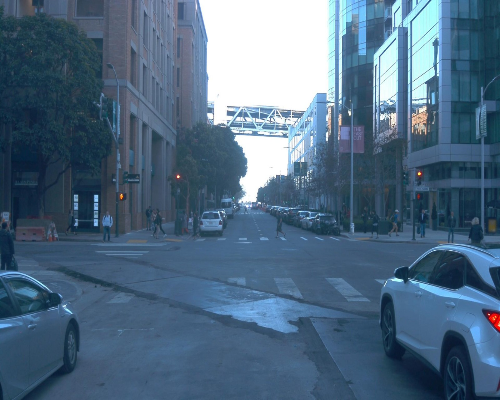

In [5]:
# download image to Google Colab content


im = cv2.imread("/content/drive/MyDrive/street_img.jpeg")
im = cv2.resize(im, (500, 400))
cv2_imshow(im)

In [6]:
def display_model(link, threshold):

  cfg = get_cfg()
  # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library

  cfg.merge_from_file(model_zoo.get_config_file(link))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # set threshold for this model
  # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(link)
  predictor = DefaultPredictor(cfg)
  outputs = predictor(im)

  # We can use `Visualizer` to draw the predictions on the image.
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


# COCO Faster RCNN with ResNet101





COCO Faster RCNN with ResNet101.
Threshold is: 0.5




model_final_f6e8b1.pkl: 243MB [00:23, 10.5MB/s]                           
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, paddin

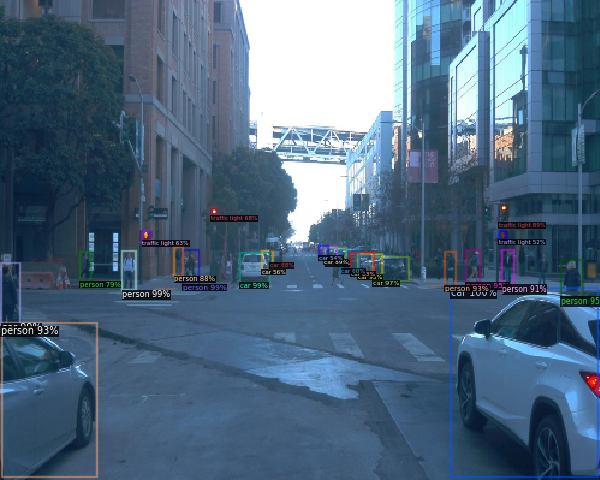

In [7]:
threshold = 0.5
model_type = "COCO Faster RCNN with ResNet101"
print( model_type + ".\nThreshold is: " + str(threshold)+"\n\n")
display_model("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml", threshold=threshold)

COCO Faster RCNN with ResNet101.
Threshold is: 0.6




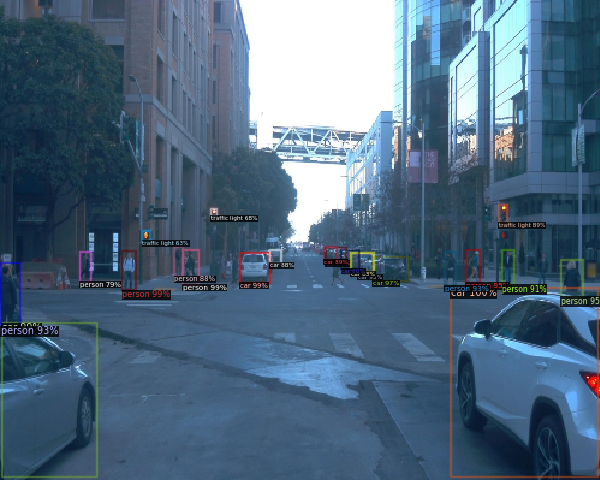

In [8]:
threshold = 0.6
model_type = "COCO Faster RCNN with ResNet101"
print( model_type + ".\nThreshold is: " + str(threshold)+"\n\n")
display_model("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml", threshold=threshold)

COCO Faster RCNN with ResNet101.
Threshold is: 0.7




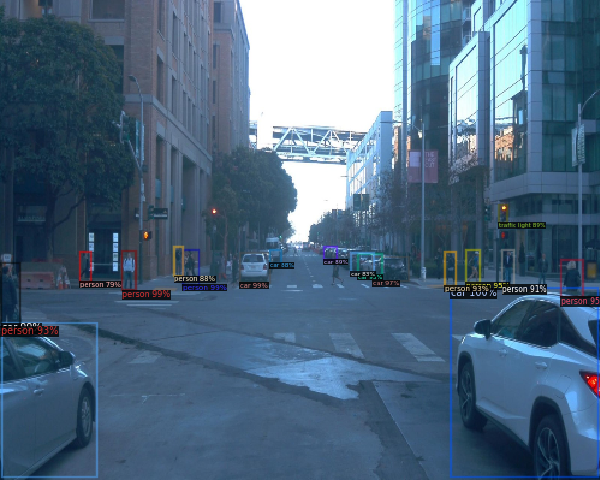

In [9]:
threshold = 0.7
model_type = "COCO Faster RCNN with ResNet101"
print( model_type + ".\nThreshold is: " + str(threshold)+"\n\n")
display_model("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml", threshold=threshold)

COCO Faster RCNN with ResNet101.
Threshold is: 0.8




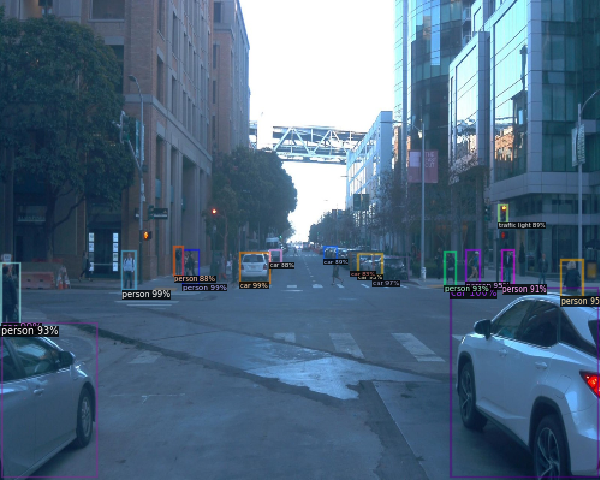

In [10]:
threshold = 0.8
model_type = "COCO Faster RCNN with ResNet101"
print( model_type + ".\nThreshold is: " + str(threshold)+"\n\n")
display_model("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml", threshold=threshold)

COCO Faster RCNN with ResNet101.
Threshold is: 0.9




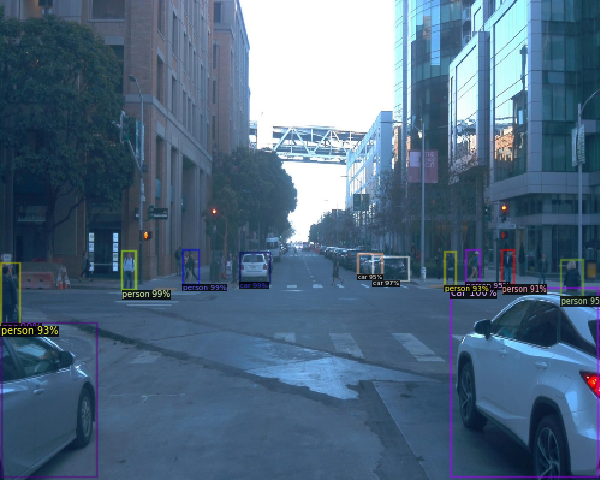

In [11]:
threshold = 0.9
model_type = "COCO Faster RCNN with ResNet101"
print( model_type + ".\nThreshold is: " + str(threshold)+"\n\n")
display_model("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml", threshold=threshold)

# Using Detectron2 to generate bounding box predictions on video

In [18]:
import json
import os
from os.path import join
from PIL import Image
import random
import sys
import time
import tqdm

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
logger = setup_logger()

train_device = "cuda"
viewer_device = "cpu"

In [25]:
video_file = "/content/drive/MyDrive/DRIVING IN KABUL CITY.mp4"

# Extract video properties
video = cv2.VideoCapture(video_file)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
  


# Initialize predictor
video_cfg = get_cfg()
video_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
video_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
video_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
video_predictor = DefaultPredictor(video_cfg)

# Initialize visualizer
video_viz = VideoVisualizer(MetadataCatalog.get(video_cfg.DATASETS.TRAIN[0]), ColorMode.IMAGE)
def runOnVideo(video, maxFrames):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """
    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = video_predictor(frame)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Draw a visualization of the predictions using the video visualizer
        visualization = video_viz.draw_instance_predictions(
                                        frame, 
                                        outputs["instances"].to(viewer_device))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
        yield visualization
        readFrames += 1
        if readFrames > maxFrames:
            break
            

# CHANGE NUM_FRAMES TO MAKE THE VIDEO LONGER
# 30 frames = 1 second
num_frames = 4980

# Uncomment line below to get the whole video
#num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize video writer
video_writer = cv2.VideoWriter('output_' + str(int(num_frames/24))+'_sec.mp4', fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                               fps=float(frames_per_second), frameSize=(width, height), isColor=True)

# Enumerate the frames of the video
for visualization in tqdm.tqdm(runOnVideo(video, num_frames), total=num_frames):

    # Write to video file
    video_writer.write(visualization)

# Release resources
video.release()
video_writer.release()


100%|█████████▉| 4973/4980 [14:25<00:01,  5.74it/s]


# Visualize Video with Predictions

Here we can download the video and display it

In [30]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/output_' + str(int(num_frames/frames_per_second))+ '_sec.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")


# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)